# Wykorzystanie testów istotności statystycznej do porównania wyników modeli uczenia maszynowego

Niniejszy notatnik jest inspirowany dwoma wpisami Jasona Brownlee: 
- [How to Use Statistical Significance Tests to Interpret Machine Learning Results](https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/)
- [Statistical Significance Tests for Comparing Machine Learning Algorithms](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/)

# Opis problemu

Załóżmy, że w [czasie prac](https://github.com/mariuszrokita/machine-learning-model-deployment/blob/master/ModelDevelopment/Titanic.ipynb) udało nam się stworzyć dwa modele uczenia maszynowego. Jakość obu modelów została oszacowana poprzez zastosowanie K-krotnej walidacji krzyżowej.

Wyniki *accuracy* dla obu modeli są następujące:

**Model A:**

[0.734375, 0.82539683, 0.88709677, 0.82258065, 0.67741935, 0.70967742, 0.79032258, 0.77419355, 0.80645161, 0.90322581]

Mean: 0.7930739567332309, STD: 0.06870856655624873

**Model B:**

[0.796875, 0.79365079, 0.88709677, 0.85483871, 0.80645161, 0.75806452, 0.80645161, 0.80645161, 0.74193548, 0.91935484]

Mean: 0.8171170954941116, STD: 0.05216682941303683

**Pytanie:** 

Czy drugi model jest istotnie lepszy od pierwszego?

# Analiza uzyskanych wyników

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

## Załadowanie danych

In [2]:
results = pd.DataFrame()

# performance results for model A
results['A'] = [0.734375, 0.82539683, 0.88709677, 0.82258065, 0.67741935, 
                0.70967742, 0.79032258, 0.77419355, 0.80645161, 0.90322581]
# performance results for model B
results['B'] = [0.796875, 0.79365079, 0.88709677, 0.85483871, 0.80645161, 
                0.75806452, 0.80645161, 0.80645161, 0.74193548, 0.91935484]

results

,A,B
0,0.734375,0.796875
1,0.825397,0.793651
2,0.887097,0.887097
3,0.822581,0.854839
4,0.677419,0.806452
5,0.709677,0.758065
6,0.790323,0.806452
7,0.774194,0.806452
8,0.806452,0.741935
9,0.903226,0.919355


## Analiza wyników

In [3]:
stats = results.describe()
stats

,A,B
count,10.000000,10.000000
mean,0.793074,0.817117
std,0.072425,0.054989
min,0.677419,0.741935
25%,0.744330,0.794457
50%,0.798387,0.806452
75%,0.824693,0.842742
max,0.903226,0.919355


Patrząc na wartości średnie możemy stwierdzić, że:
* przeciętnie model B (0.817117) jest lepszy od modelu A (0.793074). 
* w obu przypadkach średnie odchylenia wyników od średniej arytmetycznej (czyli odchylenie standardowe) są bardzo zbliżone i wynoszą: 0.054989 dla modelu B oraz 0.072425 dla modelu A.
* Mediana (50-ty percentyl) obu rozkładów jest bardzo podobna.

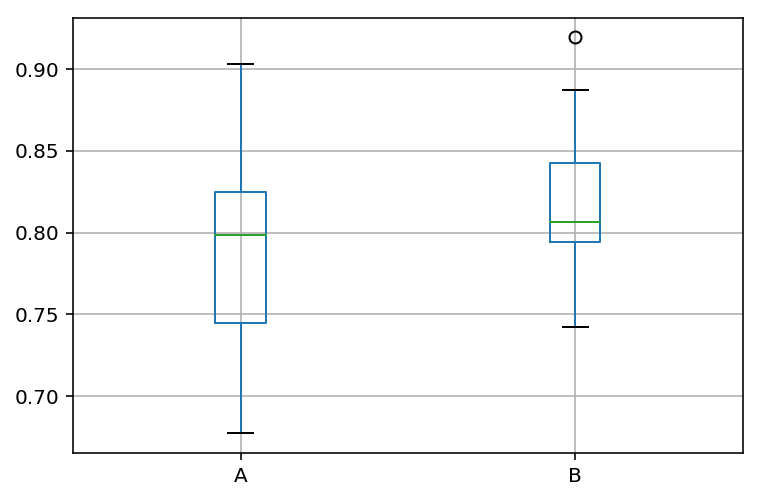

In [4]:
results.boxplot();

In [5]:
IQR = stats.loc["75%"] - stats.loc["25%"]
IQR

A    0.080363
B    0.048285
dtype: float64

Analizując wykres pudełkowy (inne nazwy to: *wykres ramka-wąsy*, *box plot*, *whisker plot*) możemy stwierdzić, że:
* wyniki modelu B są bardziej skupione wokół średniej. Wartość rozstępu międzykwartylowego (różnica między trzecim a pierwszym kwartylem) dla modelu A wynosi 0.080363 i jest prawie dwukrotnie większa niż dla modelu B (0.048285).
* model A ma uzyskał mniejszą wartość minimalną oraz wyższą wartość maksymalną od modelu B (bez uwzględniania wartości nietypowej).
* rozkład wyników modelu B w dużym stopniu pokrywa się z rozkładem wyników dla modelu A.

# Problem wyboru lepszego modelu

Wybór lepszego modelu jest bardzo częstą operacją. W końcu przecież trenujemy wiele modeli, wiele algorytmów z różnymi wartościami hiperparametrów tylko po to, by znaleźć najlepszy model i później go wykorzystać.

Mamy jednak pewien kłopot z porównywaniem wyników i stwierdzeniem, który model jest lepszy. Przykładowo - porównując wyniki dwóch modeli - nie wiemy, czy różnica w wynikach obu modeli jest statystycznie istotna, czy też jest dziełem przypadkowości.

Oczywiście mając więcej dostępnego czasu moglibyśmy uruchomić modele większą ilość razy. Uzyskalibyśmy w ten sposób więcej wyników zmniejszając ich przypadkowość. Czasami jednak jest to biznesowo niemożliwe, bo czas nas goni, a dodatkowo modele długo się trenują (np. sieć neuronowa, która trenuje się przez dwa dni).

W wyborze najlepszego modelu oraz jego ocenie mogą pomóc nam testy statystyczne.

## Wstęp do testowania hipotez

Stosując najpopularniejszą 10-krotną walidację krzyżową dla każdego modelu dostajemy próbę zawierającą 10 jego wyników. Niestety, zazwyczaj w takiej sytuacji nie jest znany rozkład tych wyników (rozkład normalny lub inny), a jest to ważne, bo decyduje o rodzaju testów, które można wykorzystać (parametryczne, nieparametryczne).

Ze względu na to, że próba ta jest nie jest zbyt liczna, tj. zawiera mniej niż 30 elementów, nie możemy skorzystać z Centralnego Twierdzenia Granicznego i jego przybliżenia, że rozkład średnich z wyników jest zbliżony do rozkładu normalnego oraz że uzyskana próbka rezultatów pochodzi z rozkładu normalnego.